In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets 

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.10.0+cpu  Device: cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
''' 3. Data Augmentation이 적용된 CIFAR10 데이터 다운로드 (Train set, Test, set 분리하기) '''
train_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                                train = True,
                                download = True,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ]))

test_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                               train = False,
                               transform = transforms.Compose([
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                   
                               ]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [5]:
''' 4. 데이터 확인하기 (1) '''
for (x_train, y_train) in train_loader:
    print('x_train:', x_train.size(), 'type:', x_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type()) 
    break

x_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


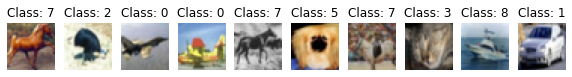

In [6]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(x_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
''' 6. ResNet 모델 설계하기 '''
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1): # BasicBlock 인스턴스의 속성.
        # in_planes : 데이터의 채널 수를 의미.
        # planes : Filter의 개수.
        
        super(BasicBlock, self).__init__() # nn.Module의 메서드를 상속.
        self.conv1 = nn.Conv2d(in_planes, planes, # Filter 정의.
                              kernel_size = 3, # Filter의 크기는 3 * 3
                              stride = stride, # Filter가 움직이는 단위.
                              padding = 1, # Zero_padding
                              bias = False) # Bias
        
        self.bn1 = nn.BatchNorm2d(planes) # Input의 분포가 달라지면 학습 속도가 느려짐. Planes 크기 데이터에 적용.
        
        self.conv2 = nn.Conv2d(planes, planes, # self.conv1, self.bn1을 통과한 결과값을 이용.
                                               # planes 인자 값을 이용해 Filter 채널 수를 정의, 개수를 정의.
                                               # Feature Map을 생성했을 때 채널 수의 변화는 없을 것.
                              kernel_size = 3,
                              stride = 1,
                              padding = 1,
                              bias = False)
        
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential() # Shortcut : 기존의 값, Convolution 및 Batch Normalization 한 결과를 더하는 과정.
        
        if stride != 1 or in_planes != planes: # 두 번째 블록부터 적용하는 shortcut을 정의하는 부분.
                                                    # stride가 1이 아니거나 in_planes가 Planes와 같지 않다면,
            self.shortcut = nn.Sequential( # shortcut을 정의하는 부분.
                
            nn.Conv2d(in_planes, planes,
                     kernel_size = 1,
                     stride = stride,
                     bias = False),
                
            nn.BatchNorm2d(planes))
            
    def forward(self, x): # Forward Propagation. 설계한 BasicBlock에 입력 ~ Output을 계산하기 까지의 과정.
        out = F.relu(self.bn1(self.conv1(x))) # self.conv1를 이용. Feature Map 생성 (채널 개수는 Planes)
                                                # Batch Normalization을 계산 (self.bn1를 이용)
                                                # Convolution과 Batch Normalization 연산을 진행한 후 ReLU 적용.
        out = self.bn2(self.conv2(out)) # self.conv2를 이용.Feature Map 생성.
                                            # Batch Normalization을 계산 (self.bn2를 이용)
        out += self.shortcut(x) # skip connection : shortcut을 통과한 결과값과 더함.
        out = F.relu(out)
        return out # Forward Propagation 의 결과값 반환.

'''
지금까지 내용
ResNet 내 Residual Block을 의미.
Skip Connection을 통해 정의한 Residual Block을 이용해
레이어를 깊게 쌓았을 때 발생하는 Vanishing Gradient 문제를 해결.
--> identity value를 더해주어 Flow가 원활하게 이루어질 수 있도록 함.
'''    
class ResNet(nn.Module): # ResNet 모델을 구현.
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        
        self.conv1 = nn.Conv2d(3, 16,
                              kernel_size = 3,
                              stride = 1,
                              padding = 1,
                              bias = False)
        
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1)
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
        self.linear = nn.Linear(64, num_classes)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [8]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [9]:
''' 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader): 
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}'.format(Epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [10]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
'''10. MLP 학습을 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n'.format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.356029
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.953021
